# 전이학습
- pre-trained 된 모델을 다른 용도로 사용하는 것을 말한다
- 특히 새로운 문제해결에 필요한 학습 데이터가 부족할 때 유용하다
- 일종의 Initialization 기법으로 볼 수도 있다
- [전이학습 개념](https://medium.com/@lorenzofamiglini/transfer-learning-with-deep-learning-machine-learning-techniques-b4052befe7e2)
- 예제
 - ResNet18모델을 활용해서 개미와 벌을 구분하는 모델을 만들겠다
 - 개미와 벌의 사진이 각각 200장씩 밖에 없는 경우


# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.12.0+cu113  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

# 데이터
- 개미와 벌 데이터 다운로드, 압축풀기

In [4]:
!curl https://download.pytorch.org/tutorial/hymenoptera_data.zip -o bee.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.0M  100 45.0M    0     0  30.2M      0  0:00:01  0:00:01 --:--:-- 30.2M


In [5]:
!unzip -oq bee.zip
# hymenoptera_data 폴더에 압축을 푼다

## 전처리, 데이터 증식 처리
- Compose 함수를 사용한다
- DataLoader를 만든다
 - 미니 배치 크기로 다룬다

In [6]:
# 데이터 변환을 처리할 내용을 담는 딕셔너리 정의
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 랜덤하게 픽셀을 선택하고 크기를 244로 조절
        transforms.RandomHorizontalFlip(),  # 좌우 반전, 50% 확률 적용
        transforms.ToTensor(),              # 0~1 사이로 정규화
                                            # RGB에 대해서 각각 평균과 표준편차를 0.5로 정규화 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),         # 중앙을 기준으로 크롭하고 크기 조절
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("./hymenoptera_data", 
        data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
        batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}

## 데이터 확인

In [7]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

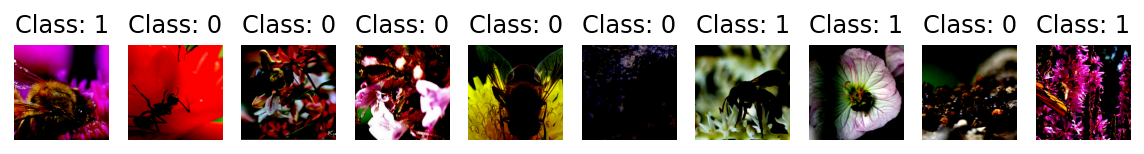

In [8]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

# 훈련과 평가 함수 정의

In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [10]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 모델 선택
- [ResNet18 모델](https://www.researchgate.net/figure/Proposed-Modified-ResNet-18-architecture-for-Bangla-HCR-In-the-diagram-conv-stands-for_fig1_323063171)


## 학습되지 않은 모델 사용

- 성능이 68% 정도 나온다

In [11]:
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()  # cuda() 사용으로 설정

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## 최적화기, 손실함수 정의


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

# print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# 미리 학습되지 않은 ResNet18를 새로 학습하는 경우
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.659051
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.837912
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.819771

[EPOCH: 1], 	Test Loss: 0.7158, 	Test Accuracy: 60.96 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.594333
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.662753
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.784079

[EPOCH: 2], 	Test Loss: 0.7422, 	Test Accuracy: 42.32 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.670634
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.605876
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.701334

[EPOCH: 3], 	Test Loss: 0.7858, 	Test Accuracy: 61.46 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.653084
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.612140
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.666606

[EPOCH: 4], 	Test Loss: 0.6899, 	Test Accuracy: 62.47 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.628324
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.665076
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.624367

## 사전 학습된 모델 사용
- 성능이 95% 정도 나온다

In [15]:
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.981316
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.796285
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.815003

[EPOCH: 1], 	Test Loss: 0.6091, 	Test Accuracy: 67.76 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.599974
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.488035
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.537259

[EPOCH: 2], 	Test Loss: 0.5248, 	Test Accuracy: 76.57 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.458708
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.489627
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.347746

[EPOCH: 3], 	Test Loss: 0.4518, 	Test Accuracy: 85.39 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.506279
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.440114
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.420578

[EPOCH: 4], 	Test Loss: 0.3783, 	Test Accuracy: 84.63 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.313380
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.393445
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.212700